In [72]:
!pip install pmdarima
!pip install optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
warnings.filterwarnings('ignore')

from pmdarima import auto_arima
from scipy import stats
from scipy.fft import fft, fftfreq
from matplotlib import rcParams
from sklearn.preprocessing import LabelEncoder
from google.colab import files
from scipy import stats
from scipy.stats import zscore
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("ggplot")
rcParams["figure.figsize"] = [15, 5]
rcParams["xtick.labelsize"] = 7
rcParams["ytick.labelsize"] = 7
rcParams["font.size"] = 7
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
uploaded = files.upload()

Saving energy_dataset.csv to energy_dataset.csv
Saving weather_features.csv to weather_features.csv


Def function

In [88]:
def inspect_data_format(df):
  inspection_results = []
  for column in df.columns:
    col_data = df[column]
    dtype = col_data.dtype
    num_unique = col_data.nunique()
    num_missing = col_data.isna().sum()
    num_missing_ratio = num_missing / len(col_data)
    inspection_results.append({
        'Column': column,
        'Data Type': dtype,
        'Unique Values': num_unique,
        'Missing Values': num_missing,
        'Missing Ratio': num_missing_ratio
        })
  inspection_df = pd.DataFrame(inspection_results)
  return inspection_df

def fourier_transform(series, t):
  series = np.asarray(series)
  N = len(series)
  T = t
  yf = fft(series)
  xf = fftfreq(N, T)[:N//2]
  plt.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
  plt.grid()
  plt.xlabel('Frequency')
  plt.ylabel('Amplitude')
  plt.title('Fourier Transform - Frequency Domain')
  plt.show()
  peak_frequency = xf[1:][np.argmax(2.0/N * np.abs(yf[1:N//2]))]
  period = 1 / peak_frequency
  print(f'Dominant frequency: {peak_frequency}')
  print(f'Seasonality period: {period}')

def seasonal_decomposition(data, period):
  rcParams["figure.figsize"] = 16, 4
  decomposition = seasonal_decompose(data, model='additive', period=period)
  decomposition.seasonal.plot()

def seasonal_decomposition_2year(data, period):
  rcParams["figure.figsize"] = 16, 4
  decomposition = seasonal_decompose(data, model='additive', period=period)
  decomposition.seasonal.loc['2017':'2018'].plot()

def trend_decomposition(data, period):
  rcParams["figure.figsize"] = 16, 4
  decomposition = seasonal_decompose(data, model='additive', period=period)
  decomposition.trend.plot()

def residual_decomposition(data, period):
  rcParams["figure.figsize"] = 16, 4
  decomposition = seasonal_decompose(data, model='additive', period=period)
  decomposition.resid.plot()

class CorrelationMatrix:
  def __init__(self, data):
    self.data = data
    self.correlation = data.corr()

  def plot_corr_matrix(self):
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
    fig, ax = plt.subplots(figsize=(15, 15))
    mask = np.triu(np.ones_like(self.correlation, dtype=bool))
    sns.heatmap(self.correlation, cmap=cmap, mask=mask, square=True, annot=True, fmt=".2f", ax=ax)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

  def sorted_correlations(self, column, n=5):
    if column not in self.correlation.columns:
      raise ValueError(f"{column} not in DataFrame columns")
    sorted_corr = self.correlation[column].sort_values(ascending=False).drop(column)
    top_n = sorted_corr.head(n)
    bottom_n = sorted_corr.tail(n)
    return top_n, bottom_n

def check_stationarity(data, n, alpha=0.05):
  partitions = np.array_split(data, n)
  for i, part in enumerate(partitions, 1):
    print(f'Partition {i}: mean={part.mean()}, variance={part.var()}')
  f_val, p_val = stats.f_oneway(*partitions)
  print(f'F-value: {f_val}, p-value: {p_val}')
  result = 'Stationary' if p_val > alpha else 'Non-Stationary'
  print(f'Partitions are {"not " if p_val > alpha else ""}significantly different --> {result}')

def adfuller_test(data):
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(data, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)

def kpss_test(data):
  print ('Results of KPSS Test:')
  kpsstest = kpss(data, regression='c', nlags="auto")
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
  for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
  print (kpss_output)

def rolling_avg_std(data, window):
  rolling_avg = data.rolling(window=window).mean()
  rolling_std = data.rolling(window=window).std()
  return rolling_avg, rolling_std

def plot_rolling_stats(data, window):
  rolling_avg, rolling_std = rolling_avg_std(data, window)
  fig, ax1 = plt.subplots()
  ax1.plot(data, label=data.name)
  ax1.plot(rolling_avg, label='Rolling Mean')
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Value')
  ax1.legend(loc='upper left')
  ax1.grid(True)
  ax2 = ax1.twinx()
  ax2.plot(rolling_std, label='Rolling Std', color='green', linestyle='--')
  ax2.set_ylabel('Standard Deviation')
  ax2.legend(loc='upper right')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

def plot_acf_pacf(data, lags):
  fig, ax = plt.subplots()
  plot_acf(data, lags=lags, ax=ax)
  fig, ax = plt.subplots()
  plot_pacf(data, lags=lags, ax=ax)
  plt.show()

def lag_plot(data, lag):
  plt.figure(figsize=(12, 6))
  pd.plotting.lag_plot(data, lag=lag)
  plt.title(f'Lag Plot (Lag = {lag})')

def create_features(df):
  df = df.copy()
  df['year'] = df.index.year
  df['month'] = df.index.month
  df['quarter'] = df.index.quarter
  df['weekofyear'] = df.index.isocalendar().week
  df['dayofweek'] = df.index.dayofweek
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  return df

def objective(trial):
  param = {
      'objective': 'reg:squarederror',
      'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 9),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
      'subsample': trial.suggest_float('subsample', 0.6, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
      }
  reg = xgb.XGBRegressor(**param, early_stopping_rounds=50)
  reg.fit(X_train_split, y_train_split, eval_set=[(X_val_split, y_val_split)], verbose=0)
  y_val_pred = reg.predict(X_val_split)
  rmse = mean_squared_error(y_val_split, y_val_pred, squared=False)
  return rmse

### **Data Understanding**

In [6]:
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

display(energy_df.head(), weather_df.head())
display(energy_df.tail(), weather_df.tail())

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,1.0,1135.0,4836.0,0.0,6073.0,63.0,95.0,85.0,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,1.0,1172.0,3931.0,0.0,6074.0,62.0,95.0,33.0,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,50.0,1148.0,2831.0,0.0,6076.0,61.0,94.0,31.0,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,NaN,108.0,1128.0,2068.0,0.0,6075.0,61.0,93.0,31.0,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89
35063,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,NaN,108.0,1069.0,1686.0,0.0,6075.0,61.0,92.0,31.0,287.0,0.0,3651.0,26.0,NaN,3117.0,24424.0,24455.0,64.27,69.88


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
178391,2018-12-31 19:00:00+01:00,Seville,287.76,287.15,288.15,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,285.76,285.15,286.15,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,285.15,285.15,285.15,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,284.15,284.15,284.15,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178395,2018-12-31 23:00:00+01:00,Seville,283.97,282.15,285.15,1029,70,3,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [7]:
display(energy_df.shape, weather_df.shape)

(35064, 29)

(178396, 17)

In [8]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [9]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [10]:
energy_df.describe().T

,count,mean,std,min,25%,50%,75%,max
generation biomass,35045.0,383.513540,85.353943,0.00,333.0000,367.00,433.00,592.00
generation fossil brown coal/lignite,35046.0,448.059208,354.568590,0.00,0.0000,509.00,757.00,999.00
generation fossil coal-derived gas,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil gas,35046.0,5622.737488,2201.830478,0.00,4126.0000,4969.00,6429.00,20034.00
generation fossil hard coal,35046.0,4256.065742,1961.601013,0.00,2527.0000,4474.00,5838.75,8359.00
generation fossil oil,35045.0,298.319789,52.520673,0.00,263.0000,300.00,330.00,449.00
generation fossil oil shale,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil peat,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation geothermal,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation hydro pumped storage aggregated,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
weather_df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,178396.0,289.618605,8.026199,262.24,283.670000,289.15,295.150000,315.600
temp_min,178396.0,288.330442,7.955491,262.24,282.483602,288.15,293.730125,315.150
temp_max,178396.0,291.091267,8.612454,262.24,284.650000,290.15,297.150000,321.150
pressure,178396.0,1069.260740,5969.631893,0.00,1013.000000,1018.00,1022.000000,1008371.000
humidity,178396.0,68.423457,21.902888,0.00,53.000000,72.00,87.000000,100.000
wind_speed,178396.0,2.470560,2.095910,0.00,1.000000,2.00,4.000000,133.000
wind_deg,178396.0,166.591190,116.611927,0.00,55.000000,177.00,270.000000,360.000
rain_1h,178396.0,0.075492,0.398847,0.00,0.000000,0.00,0.000000,12.000
rain_3h,178396.0,0.000380,0.007288,0.00,0.000000,0.00,0.000000,2.315
snow_3h,178396.0,0.004763,0.222604,0.00,0.000000,0.00,0.000000,21.500


### **Data Cleaning**

In [12]:
energy_df['time'] = pd.to_datetime(energy_df['time'], errors='coerce', utc=True)
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], errors='coerce', utc=True)

In [13]:
data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso', how='inner')

In [14]:
data.set_index('time', inplace=True)

In [15]:
drop = [
    'generation hydro pumped storage aggregated',
    'forecast solar day ahead',
    'forecast wind offshore eday ahead',
    'forecast wind onshore day ahead',
    'total load forecast',
    'price day ahead',
    'dt_iso',
    'weather_id',
    'weather_description',
    'weather_icon',
    'generation fossil oil shale',
    'generation fossil coal-derived gas',
    'generation fossil oil shale',
    'generation fossil peat',
    'generation geothermal',
    'generation marine',
    'generation wind offshore',
    'temp_min',
    'temp_max',
    'city_name'
    ]

data = data.drop(drop, axis=1)
data = data.loc[:, (data != 0).any(axis=0)]

In [23]:
label_encoder = LabelEncoder()
data['weather_main'] = label_encoder.fit_transform(data['weather_main'])
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11}


In [24]:
missing_values = data.isnull().sum()
missing_ratio = missing_values / len(data)
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Missing Ratio': missing_ratio})
missing_data = missing_data[missing_data['Missing Values'] > 0]
missing_data.sort_values(by='Missing Values', ascending=False, inplace=True)

print(missing_data)

Empty DataFrame
Columns: [Missing Values, Missing Ratio]
Index: []


In [25]:
data.fillna(method='ffill', inplace=True)

In [26]:
data.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price actual                                   0
temp                                           0
pressure                                       0
humidity                                       0
wind_speed                                     0
wind_deg            

In [27]:
data.drop_duplicates(inplace=True)

In [28]:
data.duplicated().sum()

0

In [29]:
z_scores = zscore(data['total load actual'])
outliers_z = np.abs(z_scores) > 3
num_outliers_z = np.sum(outliers_z)

Q1 = data['total load actual'].quantile(0.25)
Q3 = data['total load actual'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (data['total load actual'] < (Q1 - 1.5 * IQR)) | (data['total load actual'] > (Q3 + 1.5 * IQR))
num_outliers_iqr = np.sum(outliers_iqr)

print(f"Number of outliers using z-score method: {num_outliers_z}")
print(f"Number of outliers using IQR method: {num_outliers_iqr}")

Number of outliers using z-score method: 0
Number of outliers using IQR method: 0


In [30]:
data = data.resample('W').mean()
data = data.iloc[1:, :]

In [31]:
data.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_main
time,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-11 00:00:00+00:00,499.053571,596.750000,4841.607143,5867.583333,330.172619,555.589286,728.154762,2093.291667,5634.559524,78.785714,66.404762,1793.351190,229.095238,5096.220238,27243.357143,72.139762,279.817129,1020.126190,77.080952,1.692857,176.858333,0.030000,0.000000,0.000000,15.661905,0.672619
2015-01-18 00:00:00+00:00,499.160714,830.339286,5638.797619,6120.934524,326.910714,682.035714,1007.821429,2489.690476,6876.107143,83.035714,72.595238,715.958333,259.398810,6572.107143,30975.476190,65.483095,281.508558,1009.285714,74.258333,2.859524,216.371429,0.117857,0.000357,0.000000,35.128571,1.701190
2015-01-25 00:00:00+00:00,516.238095,750.482143,5251.214286,6615.988095,308.553571,740.005952,1122.107143,2434.726190,6774.970238,73.220238,74.458333,934.398810,238.279762,8165.119048,32299.541667,64.323929,278.914860,1005.885714,71.395238,3.085714,226.745238,0.216786,0.000357,0.086161,36.271429,2.052381
2015-02-01 00:00:00+00:00,451.952381,347.440476,4440.654762,4777.380952,296.666667,700.529762,1116.339286,3084.148810,7099.255952,44.660714,73.529762,949.880952,206.220238,9561.952381,31390.797619,53.626190,281.351853,1003.880952,71.255952,4.366667,237.130952,0.308929,0.000357,0.015625,32.376190,1.889286
2015-02-08 00:00:00+00:00,465.529762,338.767857,4750.547619,4543.898810,301.327381,520.404762,1106.625000,3185.232143,6140.380952,77.934524,66.125000,1861.130952,200.446429,5616.482143,27902.250000,58.494345,277.841912,1001.559524,70.009524,3.633333,203.246429,0.246786,0.000000,0.848214,40.950000,2.348810


In [32]:
data.tail()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_main
time,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-09 00:00:00+00:00,317.021469,297.248588,5276.430508,2934.116384,286.627119,508.195480,1388.880226,3722.064407,5739.501695,49.905085,100.053107,1596.738983,282.367232,5854.655367,29171.476836,67.002034,283.877006,1025.422599,79.770621,2.103955,167.746893,0.005763,0.0,0.0,16.967232,1.317514
2018-12-16 00:00:00+00:00,334.550857,445.804571,6338.141714,4013.925714,266.358857,265.842286,1154.683429,2337.870857,6058.256000,59.501714,93.146286,578.698286,288.066286,8436.691429,29372.206857,66.617029,282.991463,1020.422857,77.818286,2.773714,208.683429,0.060343,0.0,0.0,29.270857,1.660571
2018-12-23 00:00:00+00:00,317.591065,475.061856,7163.292096,3740.634593,274.082474,271.264605,1335.048110,2695.824742,5305.227950,56.568156,96.770905,636.935853,284.713631,6149.521191,30189.725086,67.522795,282.581442,1026.635739,75.615120,2.508591,174.839633,0.006873,0.0,0.0,22.383734,1.066438
2018-12-30 00:00:00+00:00,305.008140,406.191860,7041.818605,2354.344186,243.582558,347.754651,1164.013953,2428.311628,5923.998837,59.460465,93.456977,677.051163,293.083721,3323.281395,26179.576744,68.059151,281.035093,1028.401163,80.227907,2.026744,165.462791,0.001395,0.0,0.0,18.116279,1.213953
2019-01-06 00:00:00+00:00,296.482759,0.000000,6287.620690,2228.068966,198.793103,208.844828,1062.965517,2135.629310,6072.241379,57.982759,93.396552,1147.637931,294.681034,3133.224138,25999.853448,68.351466,280.563362,1030.232759,70.250000,2.465517,162.620690,0.000000,0.0,0.0,7.672414,0.422414


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2015-01-11 00:00:00+00:00 to 2019-01-06 00:00:00+00:00
Freq: W-SUN
Data columns (total 26 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           209 non-null    float64
 1   generation fossil brown coal/lignite         209 non-null    float64
 2   generation fossil gas                        209 non-null    float64
 3   generation fossil hard coal                  209 non-null    float64
 4   generation fossil oil                        209 non-null    float64
 5   generation hydro pumped storage consumption  209 non-null    float64
 6   generation hydro run-of-river and poundage   209 non-null    float64
 7   generation hydro water reservoir             209 non-null    float64
 8   generation nuclear                           209 non-null    float64
 9   generation othe

In [34]:
inspection_df = inspect_data_format(data)
inspection_df

,Column,Data Type,Unique Values,Missing Values,Missing Ratio
0,generation biomass,float64,209,0,0.0
1,generation fossil brown coal/lignite,float64,197,0,0.0
2,generation fossil gas,float64,209,0,0.0
3,generation fossil hard coal,float64,209,0,0.0
4,generation fossil oil,float64,209,0,0.0
5,generation hydro pumped storage consumption,float64,209,0,0.0
6,generation hydro run-of-river and poundage,float64,209,0,0.0
7,generation hydro water reservoir,float64,209,0,0.0
8,generation nuclear,float64,209,0,0.0
9,generation other,float64,209,0,0.0


### **EDA**

**Plot Time Series (Target Variable)**

Text(0.5, 1.0, 'Total Load Actual Over Time')

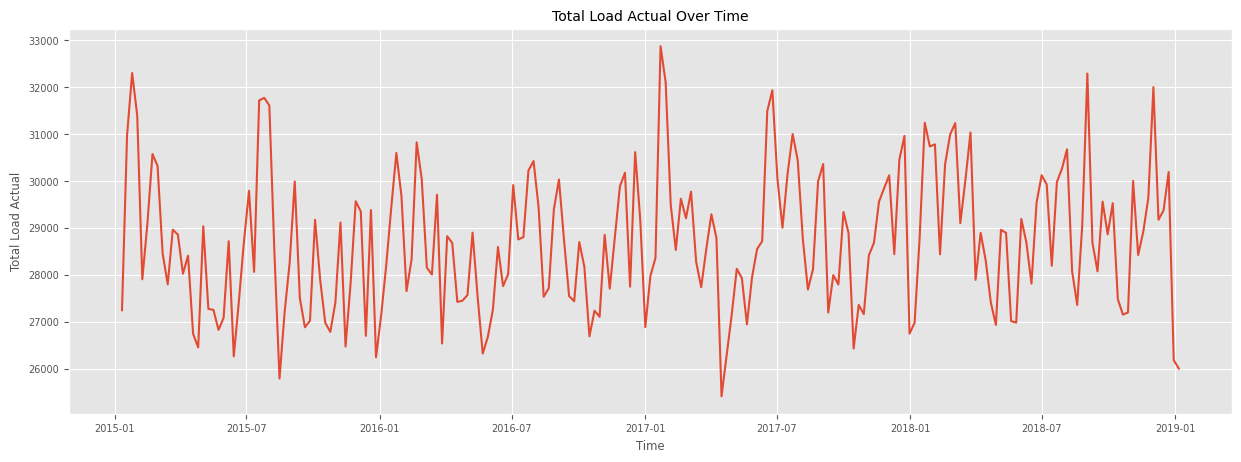

In [35]:
plt.plot(data['total load actual'], label='Total Load Actual')
plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.title('Total Load Actual Over Time')

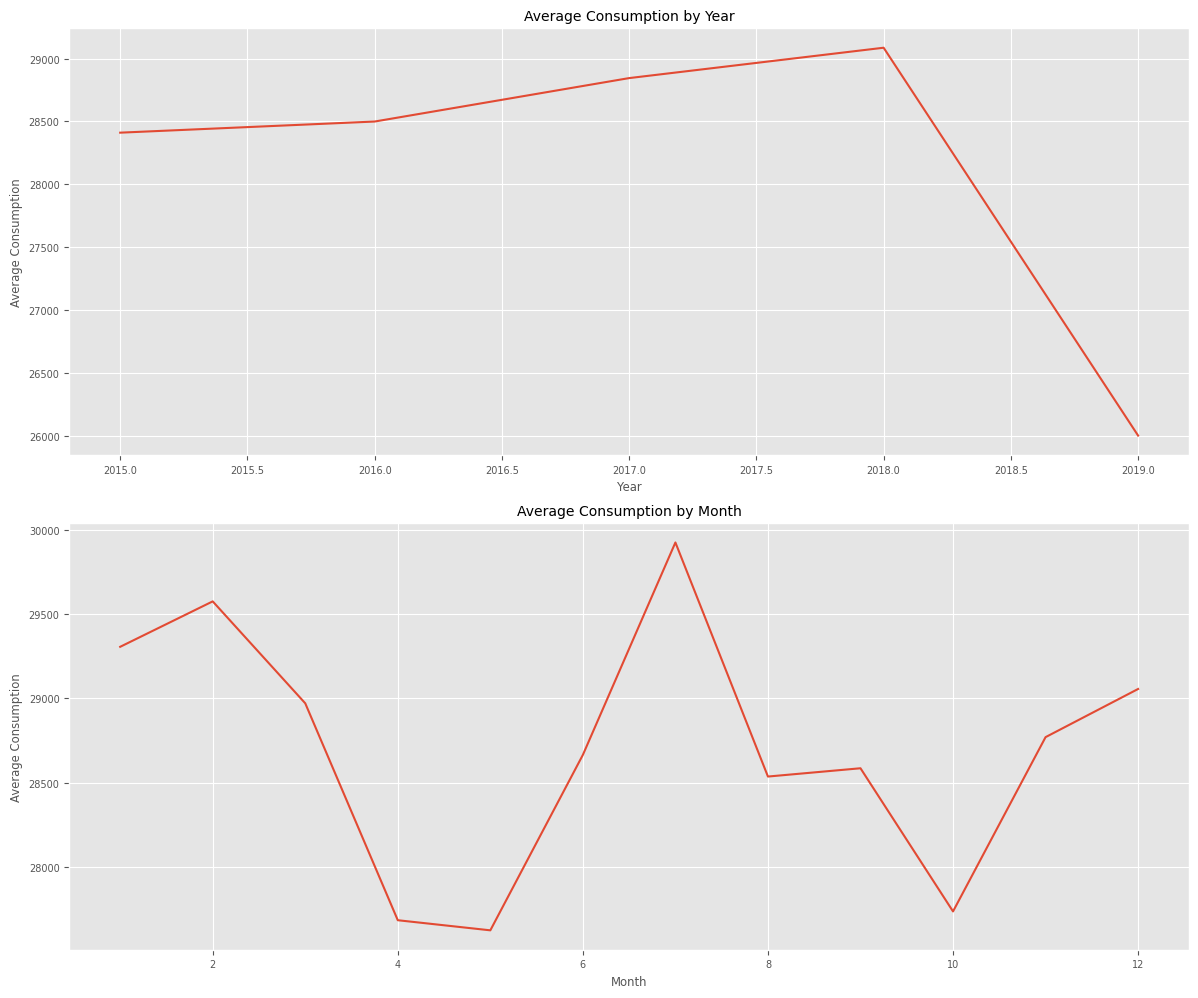

In [37]:
consumption_by_year = data['total load actual'].groupby(data.index.year).mean()
consumption_by_month = data['total load actual'].groupby(data.index.month).mean()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

consumption_by_year.plot(ax=axes[0], legend=False)
axes[0].set_title('Average Consumption by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Consumption')

consumption_by_month.plot(ax=axes[1], legend=False)
axes[1].set_title('Average Consumption by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Consumption')

plt.tight_layout()
plt.show()

**Seasonal Decomposition for 'total load actual'**

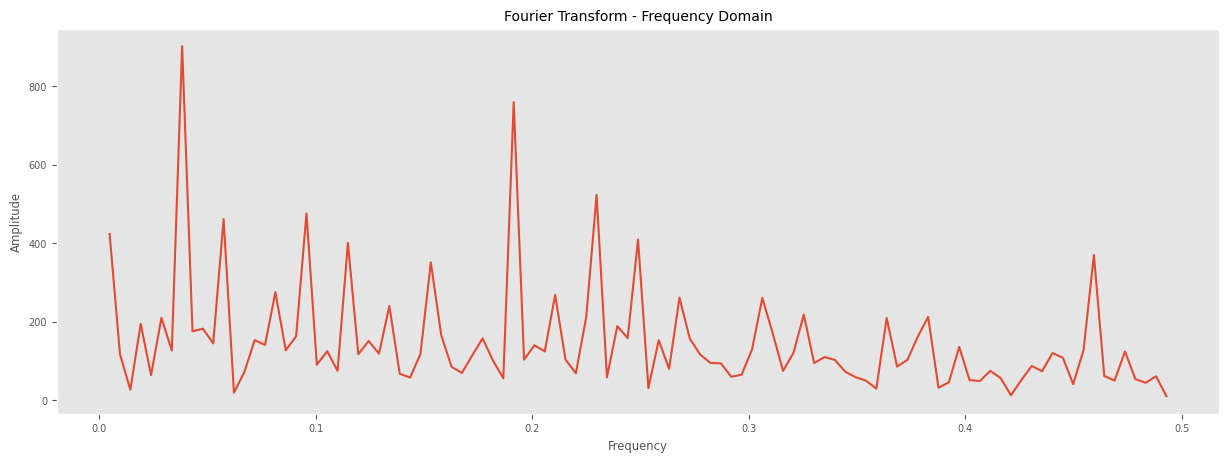

Dominant frequency: 0.03827751196172249
Seasonality period: 26.125


In [38]:
fourier_transform(data['total load actual'], 1.0)

Seasonality

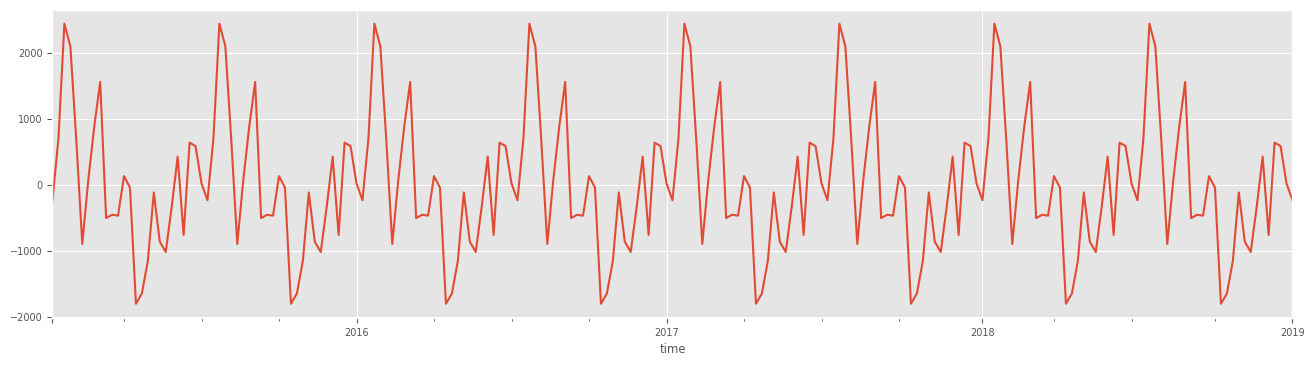

In [39]:
seasonal_decomposition(data['total load actual'], 26)

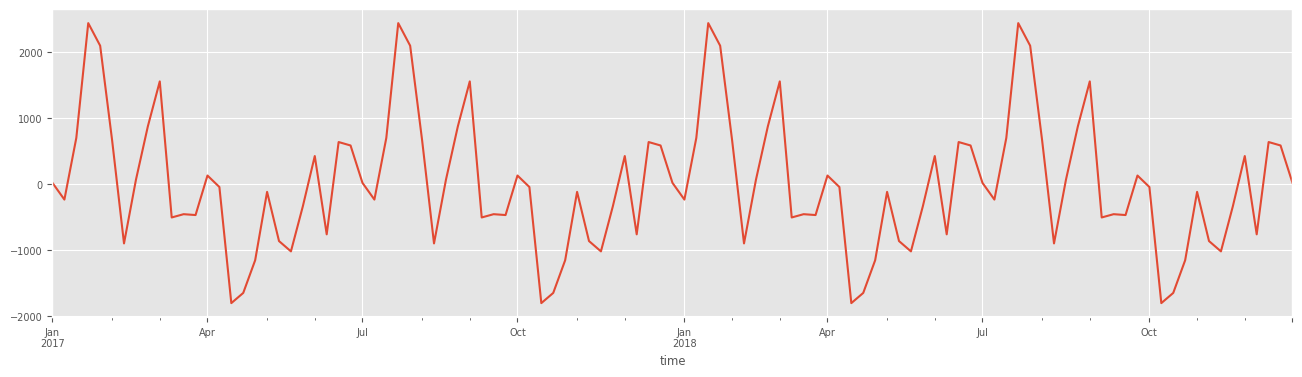

In [40]:
seasonal_decomposition_2year(data['total load actual'], 26)

Trend

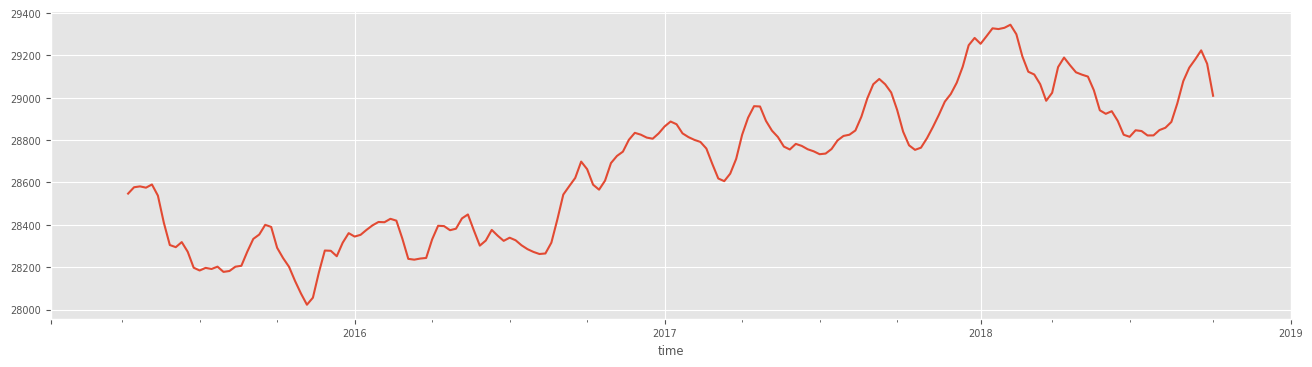

In [41]:
trend_decomposition(data['total load actual'], 26)

Noise/Residual

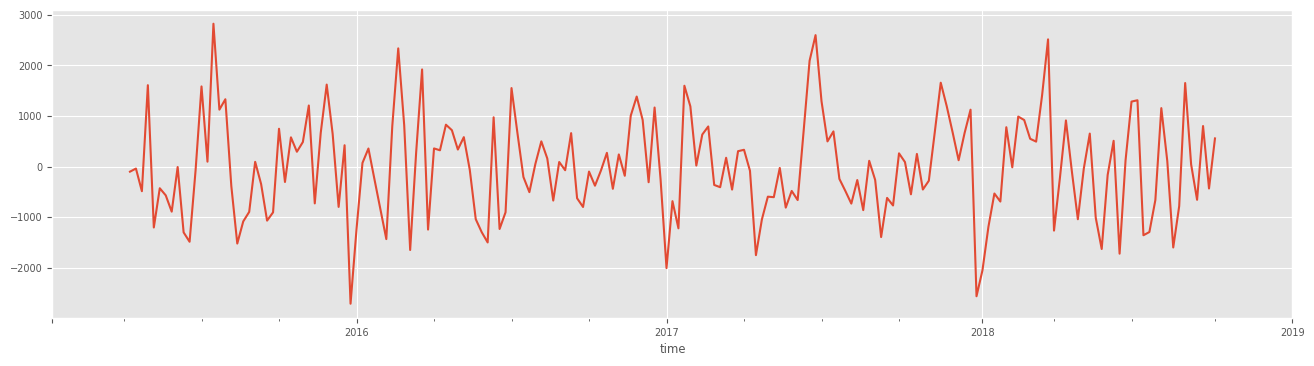

In [42]:
residual_decomposition(data['total load actual'], 26)

**Correlation Matrix**

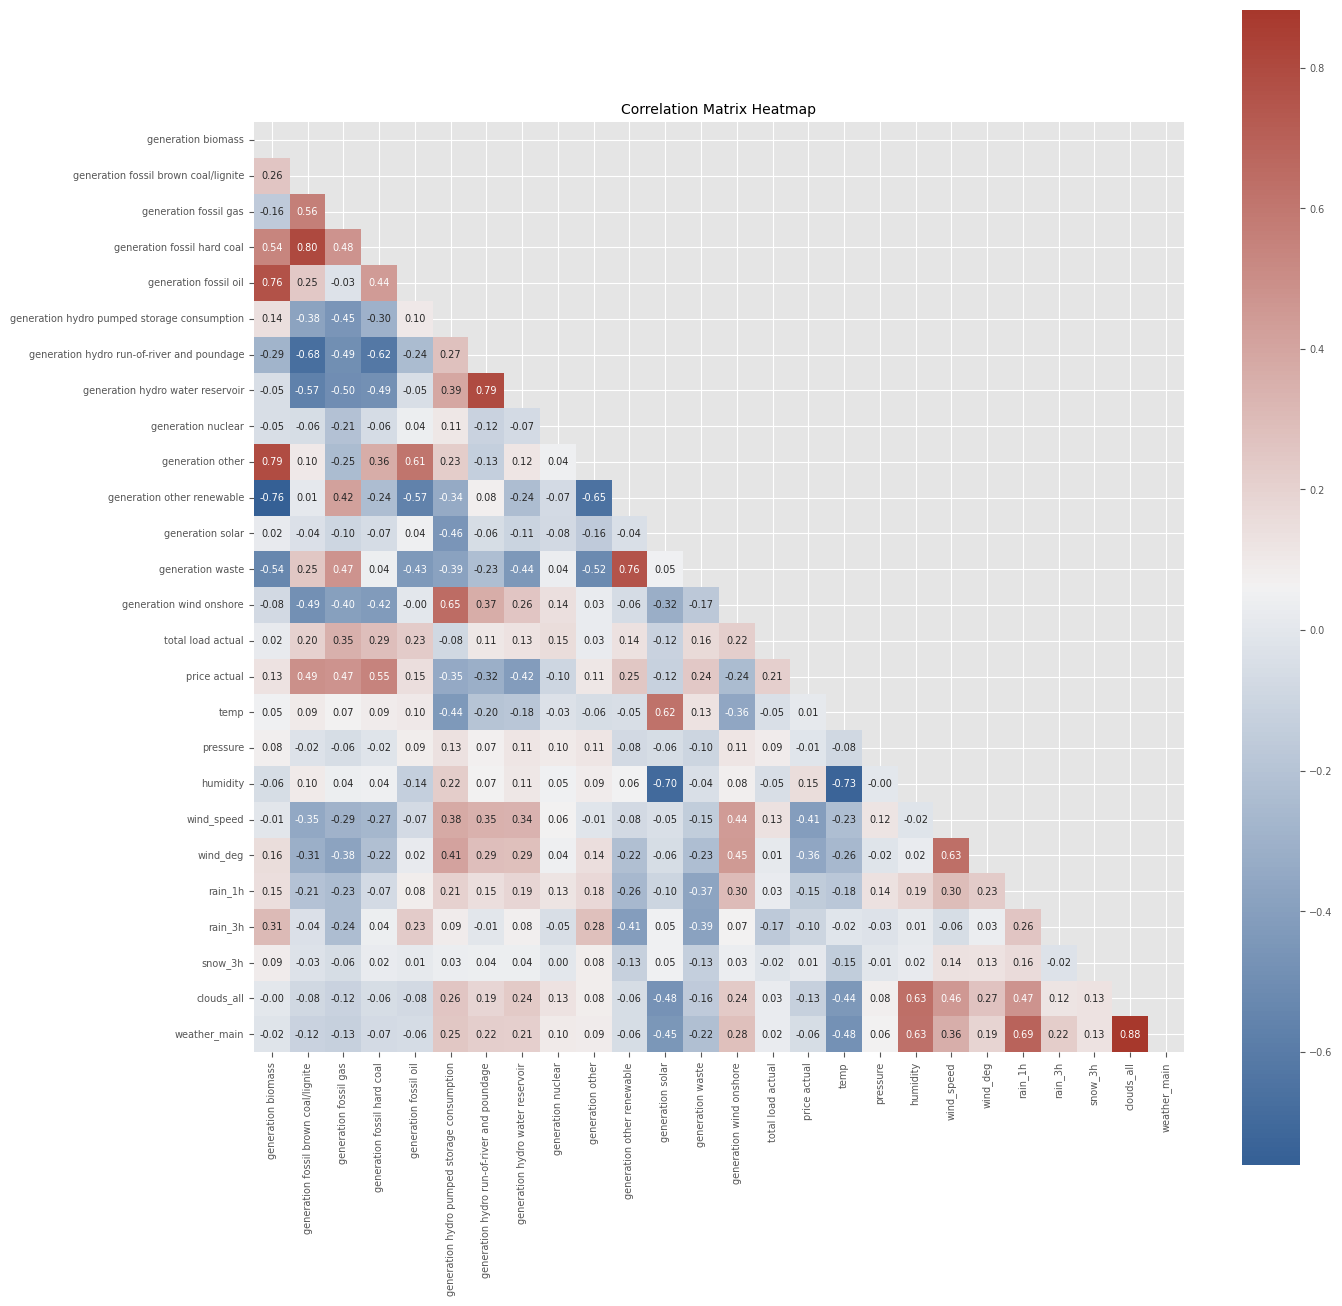

In [43]:
corr = CorrelationMatrix(data)
corr.plot_corr_matrix()

In [44]:
top, bottom = corr.sorted_correlations('total load actual', 6)
pd.concat([top, bottom], axis=1)

,total load actual,total load actual
generation fossil gas,0.353874,NaN
generation fossil hard coal,0.290903,NaN
generation fossil oil,0.231639,NaN
generation wind onshore,0.220886,NaN
price actual,0.211807,NaN
generation fossil brown coal/lignite,0.203155,NaN
snow_3h,NaN,-0.017019
temp,NaN,-0.046947
humidity,NaN,-0.053075
generation hydro pumped storage consumption,NaN,-0.083547


In [45]:
columns = list(set(top.index).union(set(bottom.index))) + ['total load actual']
seasonality_dict = {col: seasonal_decompose(data[col].dropna(), model='additive', period=26).seasonal for col in columns}

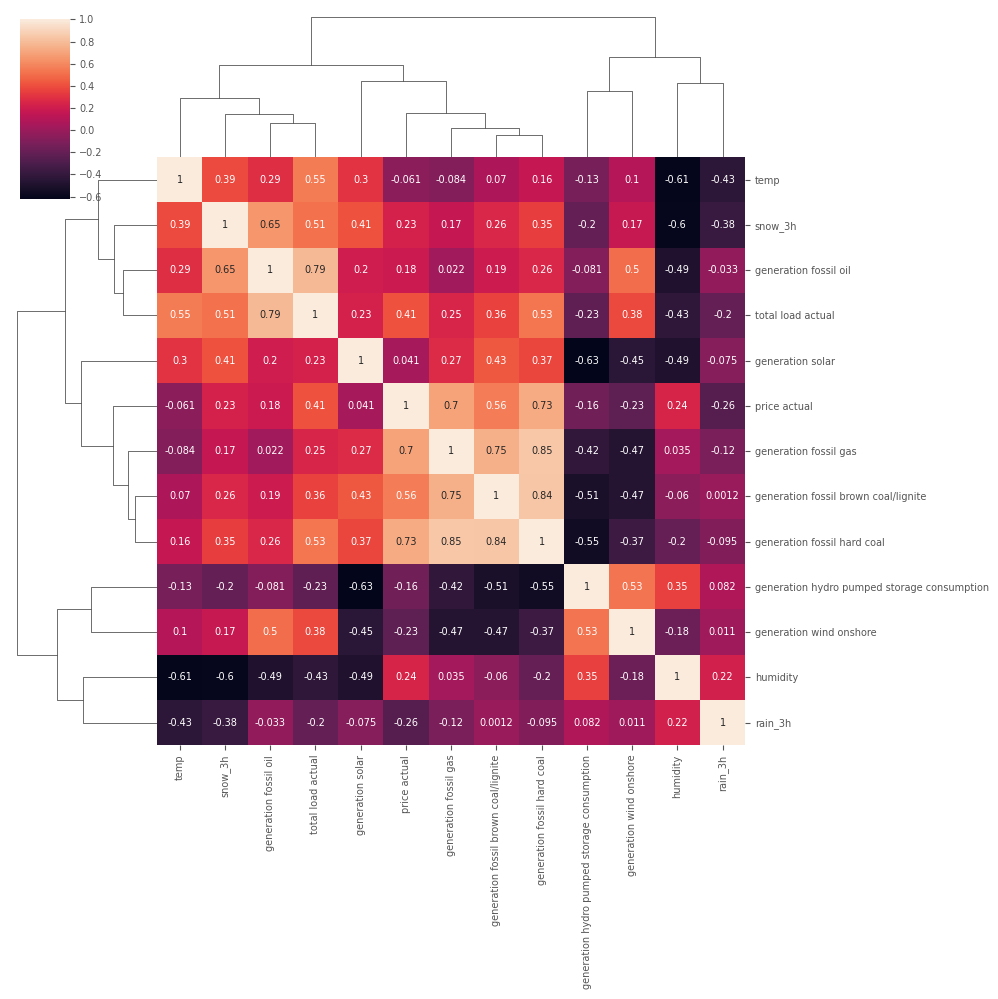

In [46]:
seasonality_corr = pd.DataFrame(seasonality_dict).corr()
sns.clustermap(seasonality_corr, annot=True, square=True)
plt.show();

**Perform Stationary Check**

In [96]:
check_stationarity(data['total load actual'], n=5)

Partition 1: mean=28497.66457791148, variance=2863945.9023698135
Partition 2: mean=28388.894738604376, variance=1582455.0540809168
Partition 3: mean=28510.096939659437, variance=2053166.8136312221
Partition 4: mean=29351.008408599904, variance=2141871.909059677
Partition 5: mean=28751.571154519093, variance=1955589.2978518389
F-value: 2.97237951048026, p-value: 0.02048064179332937
Partitions are significantly different --> Non-Stationary


In [97]:
check_stationarity(data['total load actual'], n=10)

Partition 1: mean=28615.724305774635, variance=2754715.6552251196
Partition 2: mean=28379.604850048338, variance=3087103.436012446
Partition 3: mean=28560.574272284393, variance=1800020.3582068267
Partition 4: mean=28217.215204924363, variance=1382117.3918614166
Partition 5: mean=28406.308568668173, variance=1331539.1150452117
Partition 6: mean=28613.885310650705, variance=2854831.5983974524
Partition 7: mean=29039.802619673887, variance=2364230.4794960353
Partition 8: mean=29662.214197525915, variance=1823223.9436480708
Partition 9: mean=28621.51426112315, variance=1354783.501497273
Partition 10: mean=28888.130892584828, variance=2652616.838789502
F-value: 1.6776147268415922, p-value: 0.09639256787138388
Partitions are not significantly different --> Stationary


In [47]:
adfuller_test(data['total load actual'])

Results of Dickey-Fuller Test:
Test Statistic                  -4.540561
p-value                          0.000166
#Lags Used                      14.000000
Number of Observations Used    194.000000
Critical Value (1%)             -3.464515
Critical Value (5%)             -2.876556
Critical Value (10%)            -2.574775
dtype: float64


In [48]:
kpss_test(data['total load actual'])

Results of KPSS Test:
Test Statistic           0.275979
p-value                  0.100000
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


**Rolling Avg & Std**

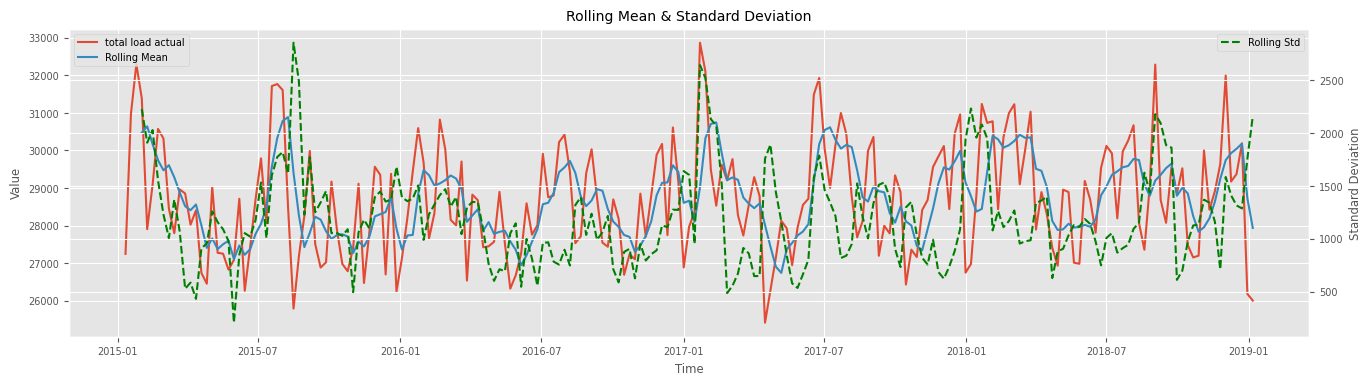

In [49]:
plot_rolling_stats(data['total load actual'], 4)

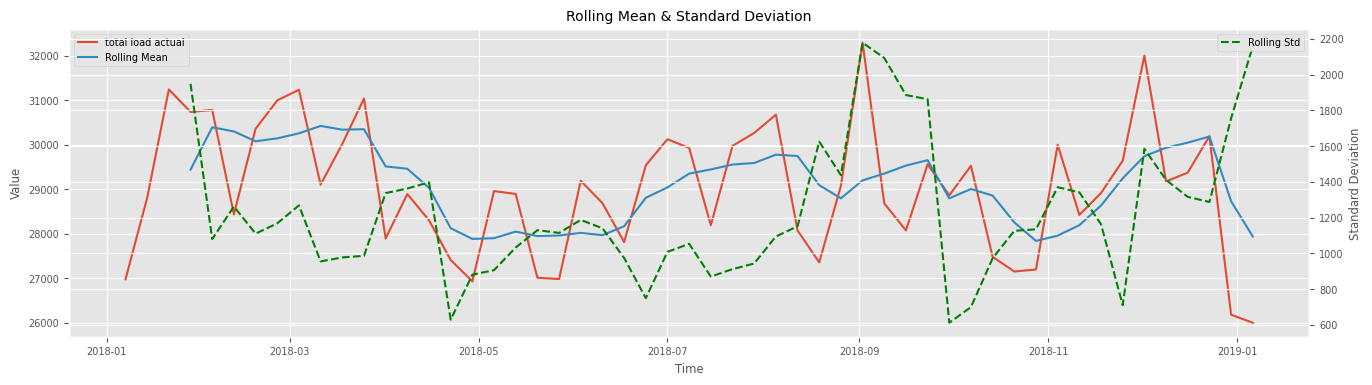

In [50]:
plot_rolling_stats(data['total load actual'].loc['2018':], 4)

**Autocorrelation and Partial-Autocorrelation**

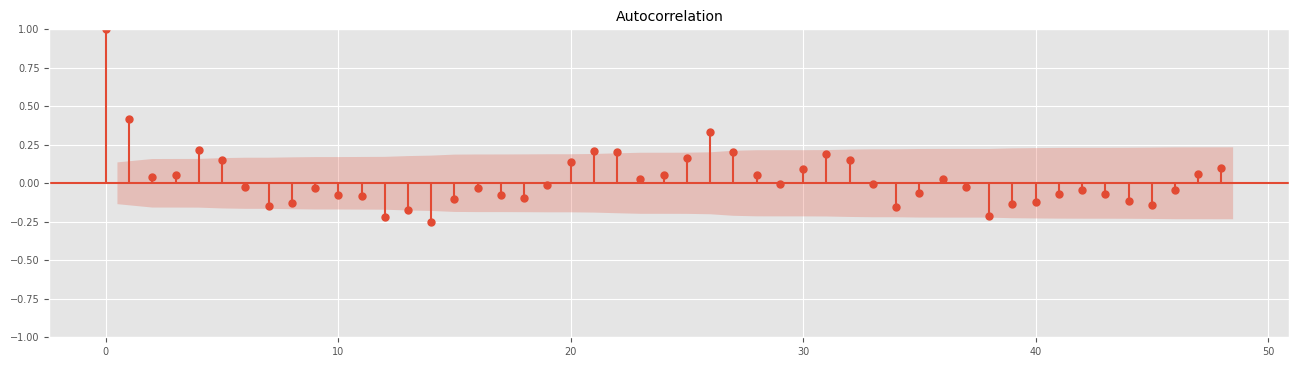

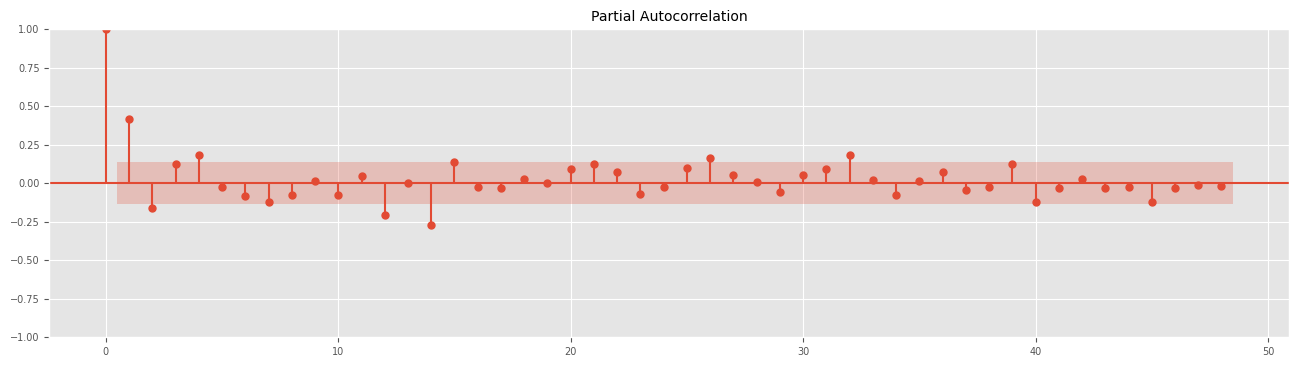

In [51]:
plot_acf_pacf(data['total load actual'], 48)

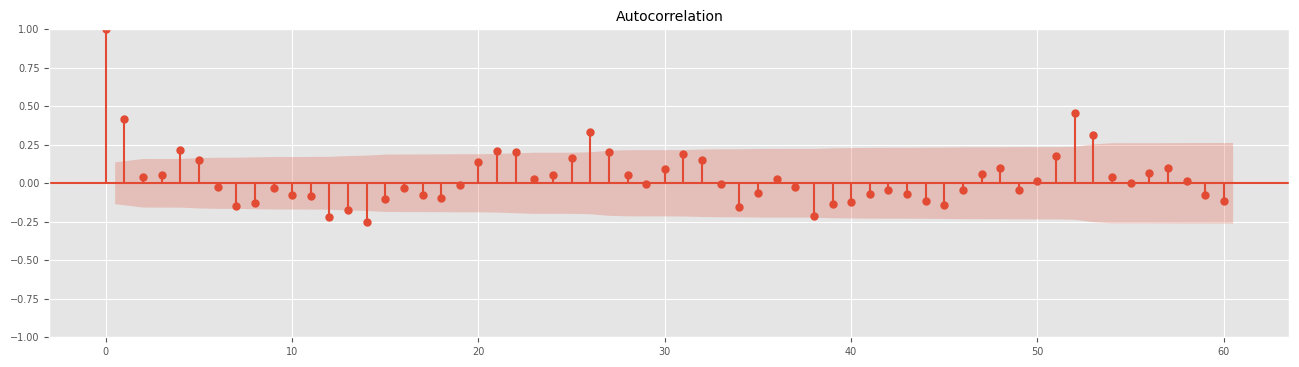

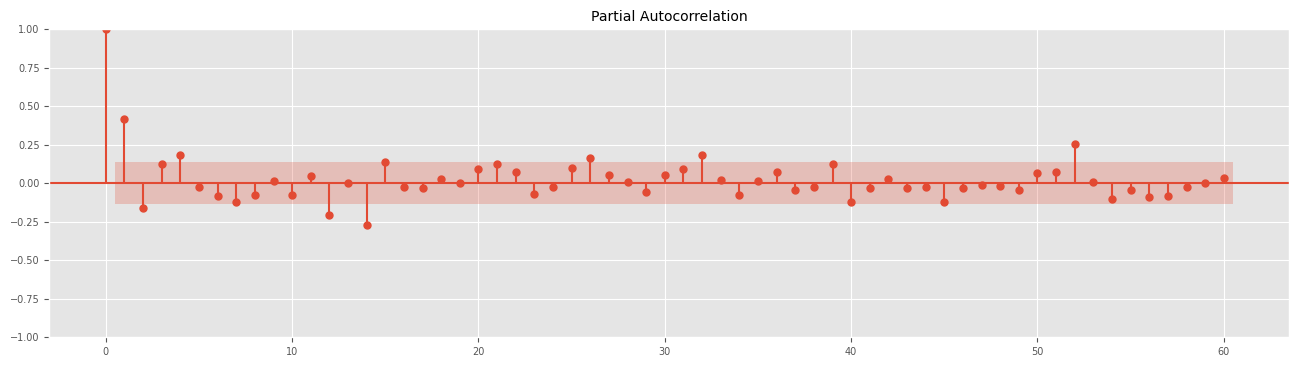

In [52]:
plot_acf_pacf(data['total load actual'], 60)

**Lag Plot**

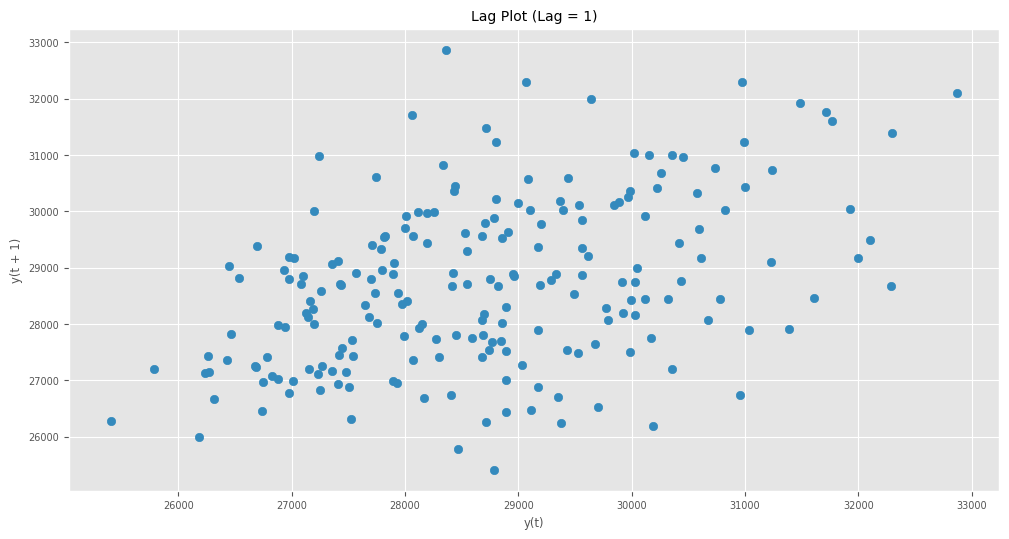

In [53]:
lag_plot(data['total load actual'], 1)

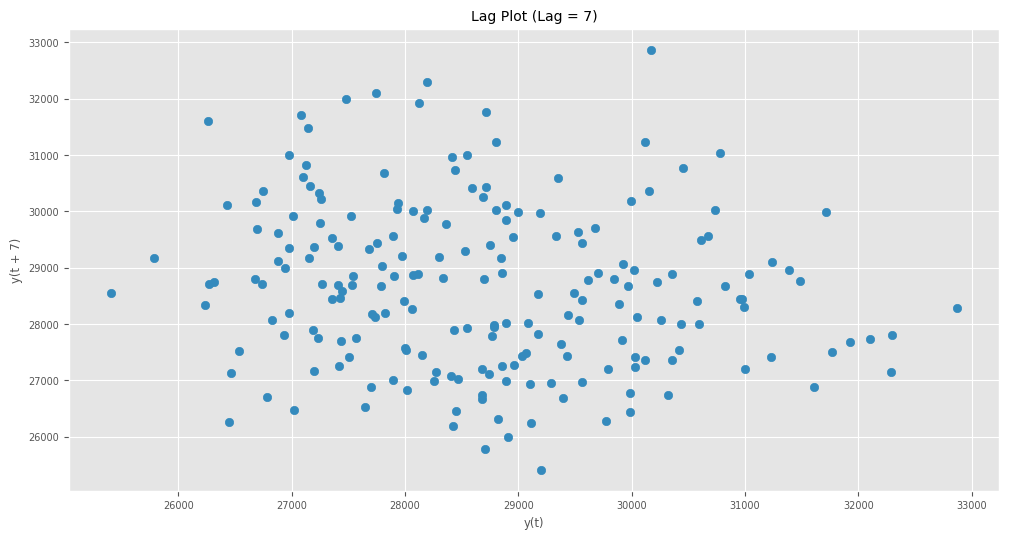

In [54]:
lag_plot(data['total load actual'], 7)

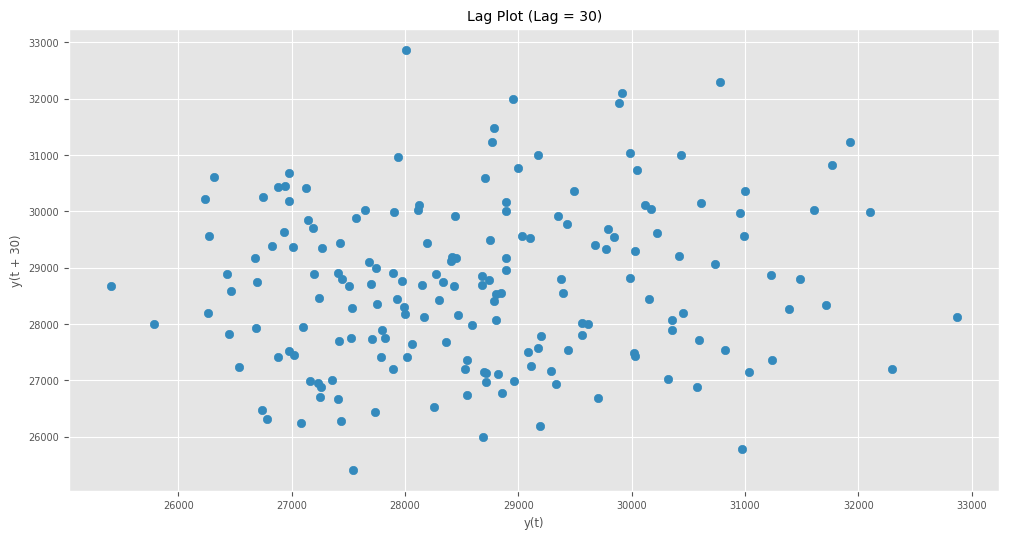

In [55]:
lag_plot(data['total load actual'], 30)

### **Modelling**

Train Test Split

In [56]:
train = data[data.index < '2018-01-01']
test = data[data.index >= '2018-01-01']

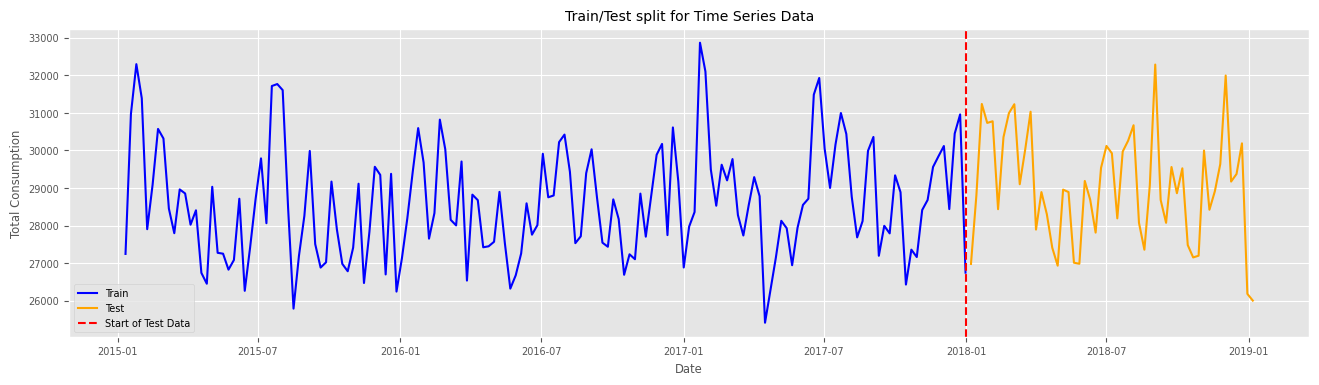

In [57]:
plt.plot(train.index, train['total load actual'], label='Train', color='blue')
plt.plot(test.index, test['total load actual'], label='Test', color='orange')
plt.axvline(x=pd.to_datetime('2018-01-01'), color='red', linestyle='--', label='Start of Test Data')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.title('Train/Test split for Time Series Data')
plt.legend()

Sarima Model

In [58]:
model=auto_arima(train['total load actual'], start_p = 0, start_q = 0, start_d = 0,
                 D = 1, m = 26, seasonal = True, test = "adf",  trace = True,
                 alpha = 0.05, information_criterion = 'aic', suppress_warnings = True,
                 stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[26] intercept   : AIC=2282.620, Time=3.43 sec
 ARIMA(0,0,0)(0,1,0)[26] intercept   : AIC=2284.932, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[26] intercept   : AIC=2274.109, Time=1.72 sec
 ARIMA(0,0,1)(0,1,1)[26] intercept   : AIC=2273.399, Time=1.37 sec
 ARIMA(0,0,0)(0,1,0)[26]             : AIC=2283.191, Time=0.10 sec
 ARIMA(0,0,1)(0,1,0)[26] intercept   : AIC=2278.571, Time=0.22 sec
 ARIMA(0,0,1)(1,1,1)[26] intercept   : AIC=2274.591, Time=2.39 sec
 ARIMA(0,0,1)(0,1,2)[26] intercept   : AIC=2274.535, Time=2.77 sec
 ARIMA(0,0,1)(1,1,0)[26] intercept   : AIC=2273.222, Time=1.87 sec
 ARIMA(0,0,1)(2,1,0)[26] intercept   : AIC=2274.535, Time=5.47 sec
 ARIMA(0,0,1)(2,1,1)[26] intercept   : AIC=2276.524, Time=3.36 sec
 ARIMA(0,0,0)(1,1,0)[26] intercept   : AIC=2281.028, Time=1.49 sec
 ARIMA(1,0,1)(1,1,0)[26] intercept   : AIC=2274.927, Time=2.52 sec
 ARIMA(0,0,2)(1,1,0)[26] intercept   : AIC=2274.415, Time=2.50 sec
 ARIMA(1,0,2)(1,1,0

In [59]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  156
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 26)   Log Likelihood               -1132.928
Date:                             Tue, 09 Jul 2024   AIC                           2271.855
Time:                                     17:03:59   BIC                           2280.458
Sample:                                 01-11-2015   HQIC                          2275.351
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2069      0.054      3.850      0.000       0.102       0.312
ar.S.L26      -0.0414      0.014     -2.967      0.003      -0.069      -0.014
sigma2      2.207e+06    3.4e+05      6.496      0.000    1.54e+06    2.87e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.95   Jarque-Bera (JB):                 2.07
Prob(Q):                              0.16   Prob(JB):                         0.35
Heteroskedasticity (H):               0.56   Skew:                             0.02
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

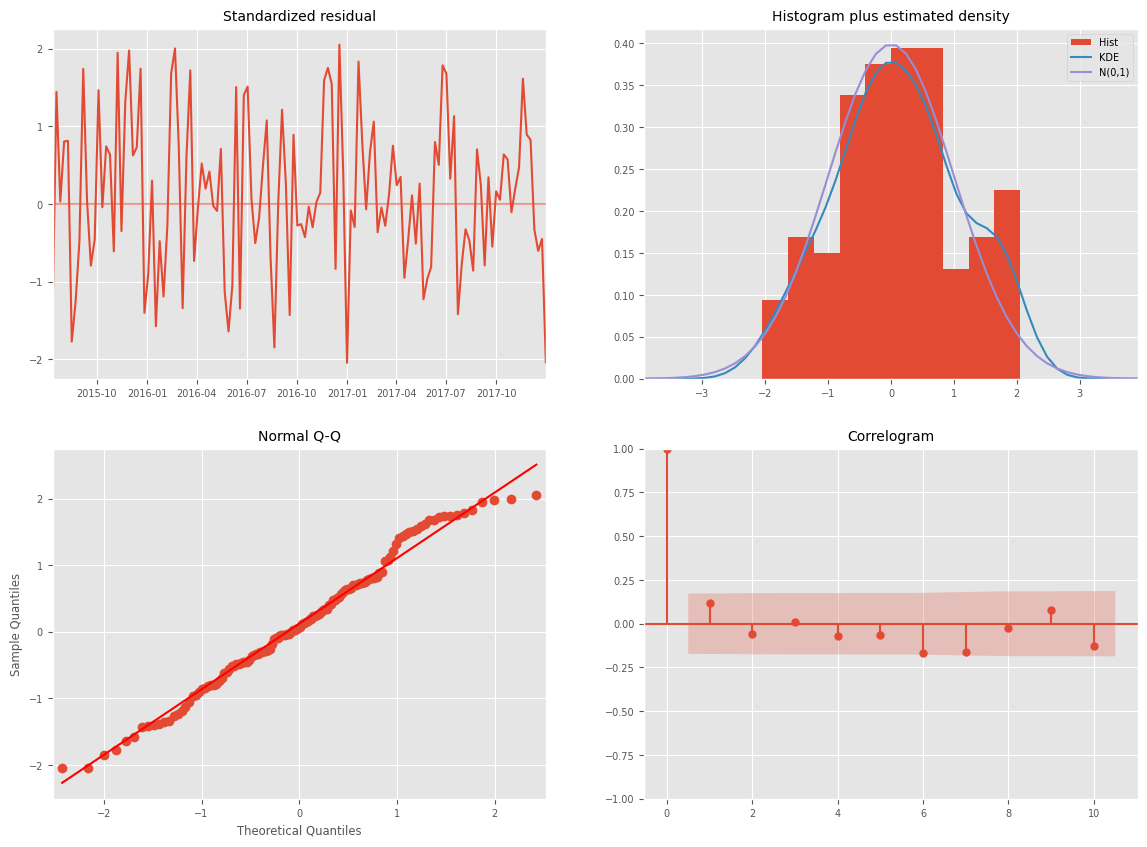

In [60]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [61]:
prediction, confint = model.predict(n_periods=len(test), return_conf_int=True)
period_index = pd.date_range(start=train.index[-1], periods=len(test) + 1, freq='W')[1:]

forecast = pd.DataFrame({'Predicted total_load_actual': prediction.round(2)}, index=period_index)
forecast_df = test.copy()
forecast_df['Forecast'] = forecast['Predicted total_load_actual']
forecast_df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_main,Forecast
time,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-07 00:00:00+00:00,318.675705,271.555315,4589.040130,2896.565076,258.533623,649.818872,1415.616052,2725.036876,6014.915401,51.247289,95.459870,1307.949024,289.033623,6245.249458,26975.981562,46.130575,283.732332,1016.495662,77.079176,3.297180,183.792842,0.116486,0.0,0.0,38.757050,2.326464,28331.99
2018-01-14 00:00:00+00:00,352.159912,444.496166,5336.485214,4556.710843,267.842278,274.346112,875.986857,1831.857612,6483.463308,39.177437,97.883899,1216.938664,325.300110,5538.084337,28806.432640,62.496309,280.127835,1017.652793,79.987952,2.329682,175.446878,0.092333,0.0,0.0,34.777656,2.039430,30082.14
2018-01-21 00:00:00+00:00,329.374269,389.618713,5727.054971,4485.947368,304.866667,623.040936,1115.658480,2209.706433,7099.269006,50.776608,101.258480,983.114620,317.299415,7291.311111,31238.704094,58.160222,282.969685,1023.557895,73.083041,2.392982,172.833918,0.024912,0.0,0.0,17.732164,1.139181,31075.40
2018-01-28 00:00:00+00:00,361.274914,265.123711,6305.013746,3013.964490,298.998855,386.233677,1116.777778,2118.957617,7101.860252,59.342497,97.623139,807.772050,311.518900,6786.379152,30733.982818,58.302600,282.507838,1025.849943,76.524628,2.387171,161.001145,0.046392,0.0,0.0,28.928981,1.808706,30507.40
2018-02-04 00:00:00+00:00,337.298206,364.302691,5778.562780,3128.720852,313.565022,557.355381,1262.868834,2831.373318,6864.624439,52.994395,91.070628,917.252242,296.319507,7461.701794,30778.256726,58.908217,280.218717,1018.789238,75.737668,2.419283,175.704036,0.077018,0.0,0.0,28.352018,1.970852,28794.80


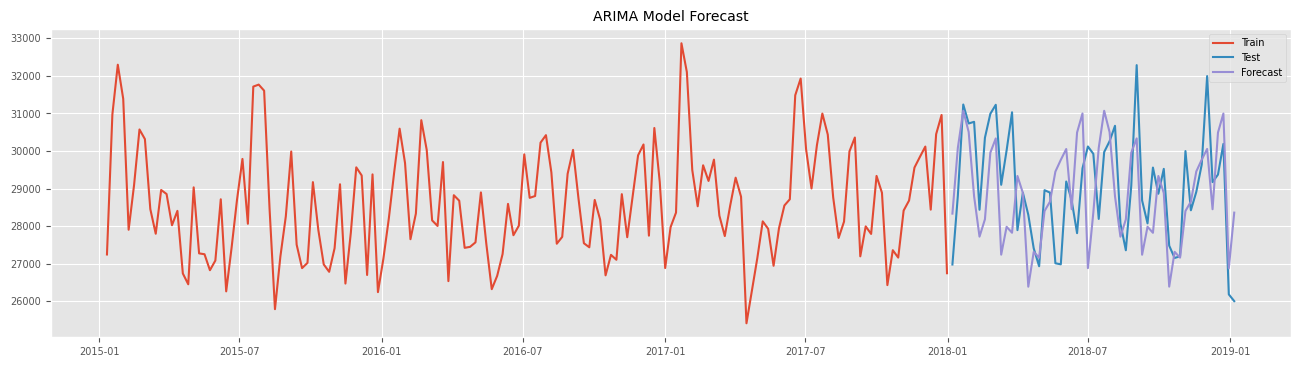

In [62]:
plt.plot(train['total load actual'], label='Train')
plt.plot(test['total load actual'], label='Test')
plt.plot(forecast_df['Forecast'], label='Forecast')
plt.legend(loc='best')
plt.title('ARIMA Model Forecast')
plt.show()

In [63]:
mse = mean_squared_error(test['total load actual'], forecast_df['Forecast'])
mae = mean_absolute_error(test['total load actual'], forecast_df['Forecast'])

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 2102209.9636067646
Mean Absolute Error: 1163.4682277123338


XGBOOST

In [64]:
train = create_features(train)
train['sarima_residuals'] = model.resid()
test = create_features(test)

features = [
    'year', 'month', 'quarter', 'weekofyear', 'dayofweek', 'dayofyear', 'dayofmonth',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil',
    'generation wind onshore', 'price actual', 'generation fossil brown coal/lignite',
    'snow_3h', 'temp', 'humidity', 'generation hydro pumped storage consumption',
    'generation solar', 'rain_3h'
]

X_train, y_train = train[features], train['sarima_residuals']
X_test, y_test = test[features], test['total load actual'] - model.predict(n_periods=len(test))

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [65]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params

print(f"Best parameters: {best_params}")

[I 2024-07-09 17:04:22,703] A new study created in memory with name: no-name-88842546-8194-43b2-ae02-de3db591fd79
[I 2024-07-09 17:04:24,610] Trial 0 finished with value: 1293.7717915577232 and parameters: {'n_estimators': 351, 'max_depth': 7, 'learning_rate': 0.020054734437578547, 'min_child_weight': 2, 'subsample': 0.7971881036449278, 'colsample_bytree': 0.9489436083221736}. Best is trial 0 with value: 1293.7717915577232.
[I 2024-07-09 17:04:25,312] Trial 1 finished with value: 1714.1146968788876 and parameters: {'n_estimators': 157, 'max_depth': 9, 'learning_rate': 0.03404908458719017, 'min_child_weight': 5, 'subsample': 0.6626851520718043, 'colsample_bytree': 0.6030045575765401}. Best is trial 0 with value: 1293.7717915577232.
[I 2024-07-09 17:04:30,747] Trial 2 finished with value: 1358.1496753535835 and parameters: {'n_estimators': 777, 'max_depth': 4, 'learning_rate': 0.02438971003131892, 'min_child_weight': 10, 'subsample': 0.6906402343795812, 'colsample_bytree': 0.688894920191

Best parameters: {'n_estimators': 783, 'max_depth': 4, 'learning_rate': 0.08192813930020522, 'min_child_weight': 8, 'subsample': 0.9793652845888136, 'colsample_bytree': 0.9484560447875103}


In [66]:
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train_split, y_train_split, eval_set=[(X_train_split, y_train_split), (X_val_split, y_val_split)], verbose=100)

[0]	validation_0-rmse:8687.84604	validation_1-rmse:8677.08139
[100]	validation_0-rmse:367.04248	validation_1-rmse:1184.02411
[200]	validation_0-rmse:110.44669	validation_1-rmse:1152.43924
[300]	validation_0-rmse:42.90097	validation_1-rmse:1143.64861
[400]	validation_0-rmse:16.98041	validation_1-rmse:1138.98059
[500]	validation_0-rmse:7.71282	validation_1-rmse:1138.14055
[600]	validation_0-rmse:3.54203	validation_1-rmse:1138.06755
[700]	validation_0-rmse:1.63878	validation_1-rmse:1137.99745
[782]	validation_0-rmse:0.96546	validation_1-rmse:1137.88434


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9484560447875103, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08192813930020522, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=783, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [67]:
y_val_pred = best_model.predict(X_val_split)
mse = mean_squared_error(y_val_split, y_val_pred)
mae = mean_absolute_error(y_val_split, y_val_pred)
rmse = mse ** 0.5

print(f'Validation Mean Squared Error: {mse}')
print(f'Validation Mean Absolute Error: {mae}')
print(f'Validation Root Mean Squared Error: {rmse}')

Validation Mean Squared Error: 1294780.7591471572
Validation Mean Absolute Error: 906.9543356306561
Validation Root Mean Squared Error: 1137.884334696263


In [68]:
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test Root Mean Squared Error: {test_rmse}')

Test Mean Squared Error: 1894872.7142861057
Test Mean Absolute Error: 1114.4081279266784
Test Root Mean Squared Error: 1376.543756764058


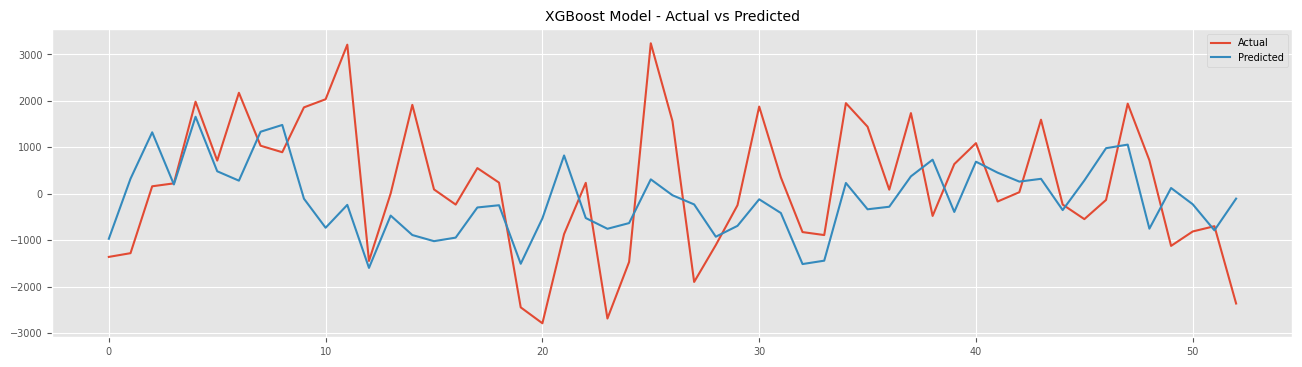

In [69]:
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.legend()
plt.title('XGBoost Model - Actual vs Predicted')
plt.show()

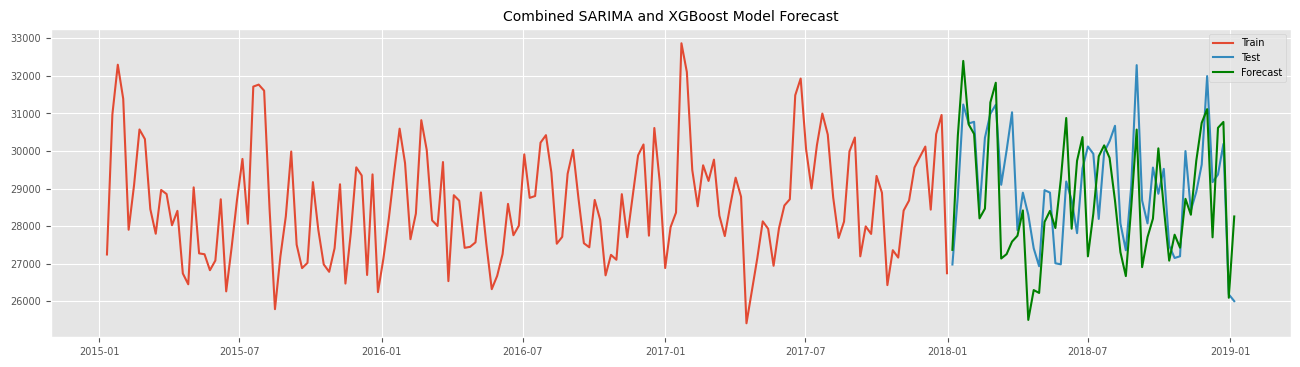

In [70]:
sarima_forecast = model.predict(n_periods=len(test))
combined_forecast = sarima_forecast + y_test_pred

plt.plot(train['total load actual'], label='Train')
plt.plot(test['total load actual'], label='Test')
plt.plot(test.index, combined_forecast, label='Forecast', color='green')
plt.legend(loc='best')
plt.title('Combined SARIMA and XGBoost Model Forecast')
plt.show()

Feature Importance

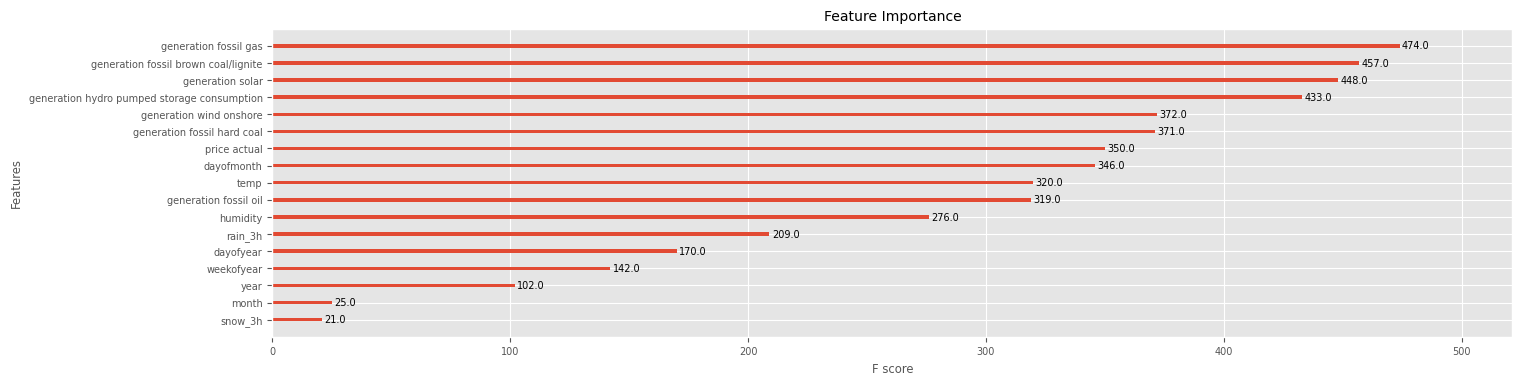

In [71]:
plot_importance(best_model)
plt.title('Feature Importance')
plt.show()